# Laboratorio Integrador - Análisis Geoespacial San Bernardo

In [1]:
## 1. Configuración Inicial
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import osmnx as ox
import contextily as ctx

In [3]:
# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [4]:
print(f"Ambiente configurado: {datetime.now()}")
print(f"Python version: {sys.version}")

Ambiente configurado: 2025-12-01 00:59:27.883206
Python version: 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:40:35) [GCC 12.3.0]


In [5]:
## 2. Definición de Paths
DATA_DIR = Path('./data')
RAW_DATA = DATA_DIR / 'raw'
PROCESSED_DATA = DATA_DIR / 'processed'
OUTPUT_DIR = Path('./outputs')
FIGURES_DIR = OUTPUT_DIR / 'figures'
MODELS_DIR = OUTPUT_DIR / 'models'

In [6]:
# Crear directorios si no existen
for path in [DATA_DIR, OUTPUT_DIR, FIGURES_DIR]:
    path.mkdir(parents=True, exist_ok=True)
    print(f"✅ Directorio listo: {path}")

✅ Directorio listo: data
✅ Directorio listo: outputs
✅ Directorio listo: outputs/figures


In [7]:
## 3. Funciones Auxiliares
def load_geodata(filepath):
    """Carga archivo geoespacial."""
    try:
        gdf = gpd.read_file(filepath)
        print(f"✅ Cargado: {filepath.name}")
        print(f"   Registros: {len(gdf)}")
        print(f"   CRS: {gdf.crs}")
        return gdf
    except Exception as e:
        print(f"❌ Error cargando {filepath}: {e}")
        return None

In [8]:
def save_figure(fig, name, dpi=300):
    """Guarda figura en alta resolución."""
    filepath = FIGURES_DIR / f"{name}.png"
    fig.savefig(filepath, dpi=dpi, bbox_inches='tight')
    print(f"📊 Figura guardada: {filepath}")

In [9]:
def create_map_with_context(gdfs_dict, title="Mapa San Bernardo"):
    """Crea mapa con contexto real."""
    fig, ax = plt.subplots(figsize=(15, 12))
    
    # Determinar bounds para el zoom
    all_bounds = []
    for name, gdf in gdfs_dict.items():
        if gdf is not None:
            all_bounds.append(gdf.total_bounds)
    
    if all_bounds:
        min_x = min(bounds[0] for bounds in all_bounds)
        min_y = min(bounds[1] for bounds in all_bounds)
        max_x = max(bounds[2] for bounds in all_bounds)
        max_y = max(bounds[3] for bounds in all_bounds)
    else:
        return fig, ax
    
    try:
        # Intentar añadir mapa base
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, 
                       zoom=12, crs='EPSG:4326')
        print("✅ Mapa base cargado")
    except Exception as e:
        print(f"⚠️ No se pudo cargar mapa base: {e}")
        print("🗺️ Creando mapa sin contexto base...")
    
    # Añadir cada capa
    for name, gdf in gdfs_dict.items():
        if gdf is not None:
            print(f"Añadiendo capa: {name} ({len(gdf)} elementos)")
            
            # Estilos según tipo
            if name == 'boundaries':
                gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=3, label=name)
            elif name == 'buildings':
                gdf.plot(ax=ax, facecolor='blue', alpha=0.3, edgecolor='darkblue', label=name)
            elif name == 'amenities':
                # Filtrar solo puntos para mejor visualización
                points = gdf[gdf.geometry.type == 'Point']
                if len(points) > 0:
                    points.plot(ax=ax, color='red', markersize=15, alpha=0.8, label=name)
                else:
                    gdf.plot(ax=ax, color='red', markersize=10, alpha=0.7, label=name)
    
    # Ajustar límites
    ax.set_xlim(min_x - 0.01, max_x + 0.01)
    ax.set_ylim(min_y - 0.01, max_y + 0.01)
    
    ax.set_title(title, fontsize=16)
    ax.legend()
    ax.set_xlabel('Longitud')
    ax.set_ylabel('Latitud')
    plt.tight_layout()
    return fig, ax

In [10]:
## 4. Carga de Datos de San Bernardo
print("\n📍 Cargando datos de San Bernardo...")


📍 Cargando datos de San Bernardo...


In [11]:
# Cargar datos espaciales
buildings = load_geodata(RAW_DATA / 'osm_buildings.geojson')
amenities = load_geodata(RAW_DATA / 'osm_amenities.geojson')

✅ Cargado: osm_buildings.geojson
   Registros: 8370
   CRS: EPSG:4326
✅ Cargado: osm_amenities.geojson
   Registros: 765
   CRS: EPSG:4326


In [12]:
# Descargar límites administrativos
print("🗺️ Descargando límites de San Bernardo...")
try:
    boundaries = ox.geocode_to_gdf('San Bernardo, Chile')
    print(f"✅ Límites descargados: {len(boundaries)} polígonos")
except Exception as e:
    print(f"❌ Error descargando límites: {e}")
    boundaries = None

🗺️ Descargando límites de San Bernardo...
✅ Límites descargados: 1 polígonos


In [13]:
# Resumen de datos
print(f"\n📊 Resumen de datos cargados:")
print(f"   Edificios: {len(buildings) if buildings is not None else 0}")
print(f"   Amenidades: {len(amenities) if amenities is not None else 0}")
print(f"   Límites: {len(boundaries) if boundaries is not None else 0}")


📊 Resumen de datos cargados:
   Edificios: 8370
   Amenidades: 765
   Límites: 1


# 5. Análisis Exploratorio

In [14]:
# Análisis de edificios
if buildings is not None:
    print("\n🏢 Análisis de Edificios:")
    print(f"Total: {len(buildings)} edificios")
    print(f"CRS: {buildings.crs}")
    print(f"Tipos de geometría: {buildings.geometry.type.unique()}")
    
    # Tipos de edificios más comunes
    if 'building' in buildings.columns:
        building_types = buildings['building'].value_counts().head(10)
        print(f"\nTop 10 tipos de edificios:")
        print(building_types)


🏢 Análisis de Edificios:
Total: 8370 edificios
CRS: EPSG:4326
Tipos de geometría: ['Polygon']

Top 10 tipos de edificios:
building
house          5069
yes            2727
apartments      160
industrial      113
residential      96
roof             70
commercial       65
school           27
hospital         15
church            8
Name: count, dtype: int64


In [15]:
# Análisis de amenidades
if amenities is not None:
    print("\n🏪 Análisis de Amenidades:")
    print(f"Total: {len(amenities)} amenidades")
    print(f"Tipos de geometría: {amenities.geometry.type.unique()}")
    
    # Tipos de amenidades más comunes
    if 'amenity' in amenities.columns:
        amenity_types = amenities['amenity'].value_counts().head(10)
        print(f"\nTop 10 tipos de amenidades:")
        print(amenity_types)


🏪 Análisis de Amenidades:
Total: 765 amenidades
Tipos de geometría: ['Point' 'Polygon']

Top 10 tipos de amenidades:
amenity
school              167
bench                94
restaurant           67
parking              59
kindergarten         42
fast_food            39
pharmacy             34
fuel                 30
place_of_worship     25
atm                  19
Name: count, dtype: int64


# 6. Visualizaciones

In [16]:
# Mapa completo con contexto
print("\n🗺️ Creando mapa completo...")
gdfs = {
    'boundaries': boundaries,
    'buildings': buildings,
    'amenities': amenities
}


🗺️ Creando mapa completo...


✅ Mapa base cargado
Añadiendo capa: boundaries (1 elementos)
Añadiendo capa: buildings (8370 elementos)
Añadiendo capa: amenities (765 elementos)


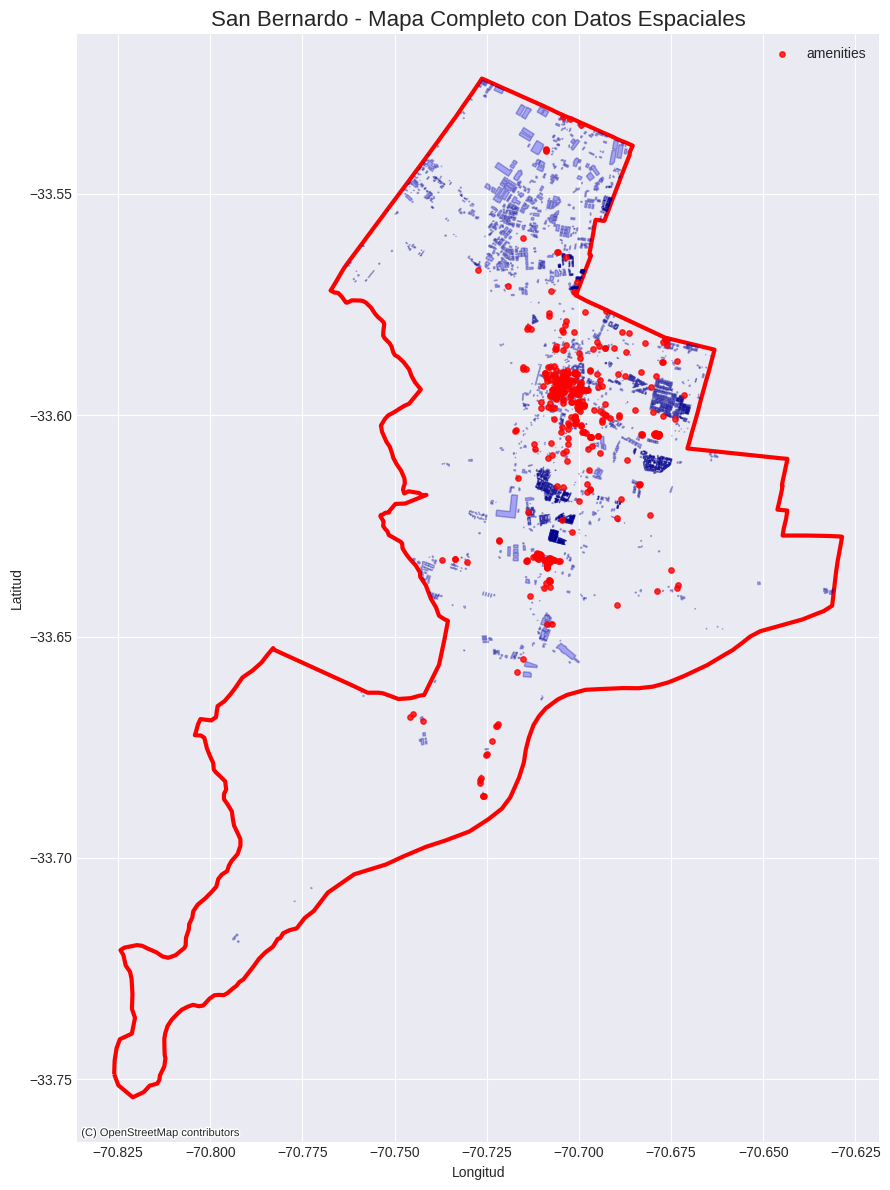

In [17]:
try:
    fig, ax = create_map_with_context(gdfs, "San Bernardo - Mapa Completo con Datos Espaciales")
    plt.show()
except Exception as e:
    print(f"❌ Error en mapa completo: {e}")
    print("🗺️ Creando mapa simple...")
    
    # Mapa simple de respaldo
    fig, ax = plt.subplots(figsize=(12, 10))
    
    if boundaries is not None:
        boundaries.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=3, label='Límites')
    
    if buildings is not None:
        buildings.plot(ax=ax, facecolor='blue', alpha=0.3, edgecolor='darkblue', label='Edificios')
    
    if amenities is not None:
        points = amenities[amenities.geometry.type == 'Point']
        if len(points) > 0:
            points.plot(ax=ax, color='red', markersize=15, alpha=0.8, label='Amenidades')
    
    ax.set_title('San Bernardo - Mapa Simple', fontsize=16)
    ax.legend()
    ax.set_xlabel('Longitud')
    ax.set_ylabel('Latitud')
    plt.tight_layout()
    plt.show()

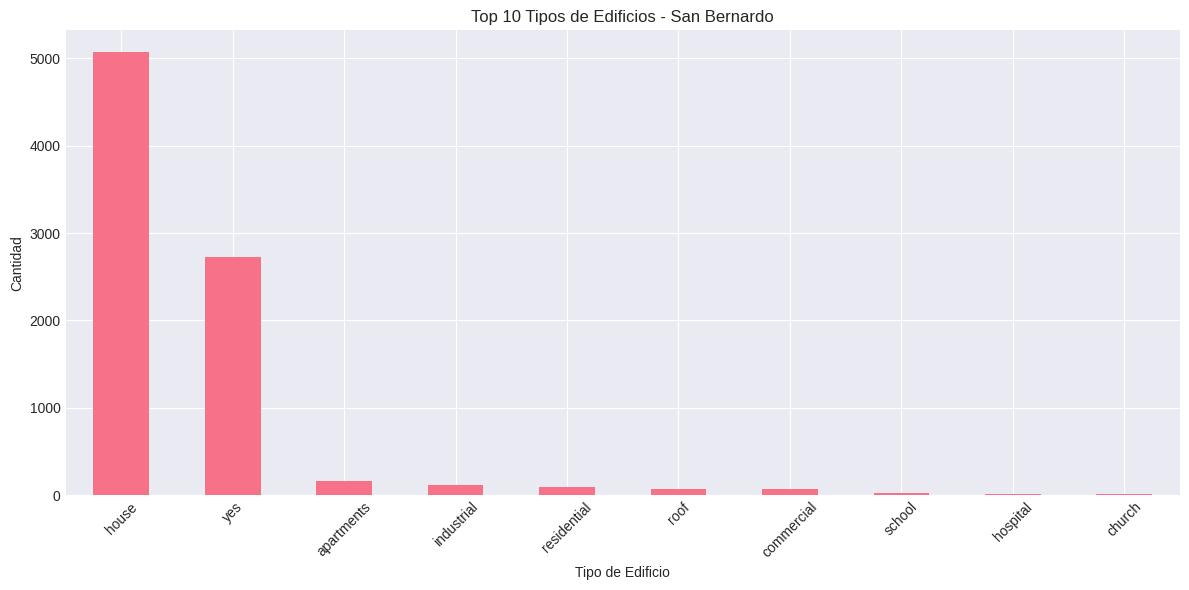

In [18]:
# Gráficos de distribución
if buildings is not None and 'building' in buildings.columns:
    plt.figure(figsize=(12, 6))
    buildings['building'].value_counts().head(10).plot(kind='bar')
    plt.title('Top 10 Tipos de Edificios - San Bernardo')
    plt.xlabel('Tipo de Edificio')
    plt.ylabel('Cantidad')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

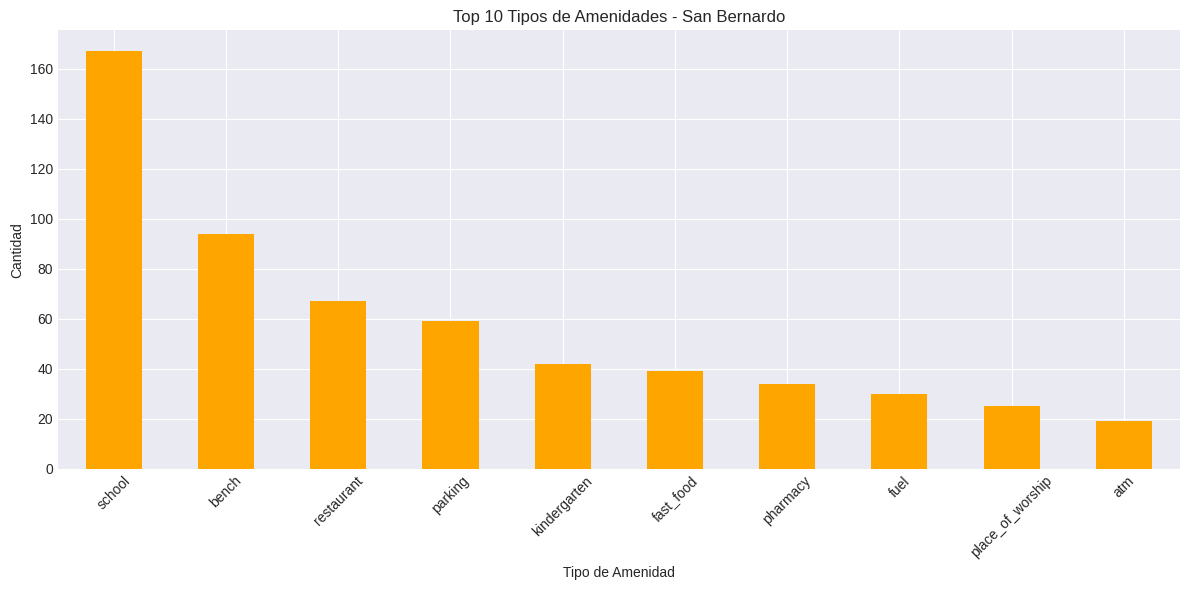

In [19]:
if amenities is not None and 'amenity' in amenities.columns:
    plt.figure(figsize=(12, 6))
    amenities['amenity'].value_counts().head(10).plot(kind='bar', color='orange')
    plt.title('Top 10 Tipos de Amenidades - San Bernardo')
    plt.xlabel('Tipo de Amenidad')
    plt.ylabel('Cantidad')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [20]:
## 7. Resumen del Análisis
print("\n" + "="*60)
print("RESUMEN DEL ANÁLISIS EXPLORATORIO - SAN BERNARDO")
print("="*60)


RESUMEN DEL ANÁLISIS EXPLORATORIO - SAN BERNARDO


In [21]:
print(f"\n📊 Estadísticas Generales:")
print(f"   Fecha y hora: {datetime.now()}")
print(f"   Comuna: San Bernardo, Chile")
print(f"   Total edificios: {len(buildings) if buildings is not None else 0}")
print(f"   Total amenidades: {len(amenities) if amenities is not None else 0}")


📊 Estadísticas Generales:
   Fecha y hora: 2025-12-01 00:59:42.739527
   Comuna: San Bernardo, Chile
   Total edificios: 8370
   Total amenidades: 765


In [22]:
if buildings is not None:
    bounds = buildings.total_bounds
    print(f"\n📍 Extensión Geográfica:")
    print(f"   Min X: {bounds[0]:.4f}, Min Y: {bounds[1]:.4f}")
    print(f"   Max X: {bounds[2]:.4f}, Max Y: {bounds[3]:.4f}")


📍 Extensión Geográfica:
   Min X: -70.7940, Min Y: -33.7191
   Max X: -70.6310, Max Y: -33.5243


In [23]:
print(f"\n📝 Próximos pasos:")
print("   1. Análisis de densidad espacial")
print("   2. Cálculo de autocorrelación espacial")
print("   3. Identificación de hot spots")
print("   4. Modelos de machine learning geoespacial")
print("   5. Desarrollo de dashboard interactivo")


📝 Próximos pasos:
   1. Análisis de densidad espacial
   2. Cálculo de autocorrelación espacial
   3. Identificación de hot spots
   4. Modelos de machine learning geoespacial
   5. Desarrollo de dashboard interactivo


In [25]:
print("\n✅ Análisis exploratorio completado exitosamente!")


✅ Análisis exploratorio completado exitosamente!
